# Windkessel

In [1]:
import numpy as np
import torch

In [2]:
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [4]:
import sys
sys.path.insert(0, './python')

In [5]:
from windkessel import model, utils

In [6]:
patient_id = 145796

### Предобработка

In [7]:
test_model = model.WindkesselModel()

In [8]:
from scipy.integrate import solve_ivp

In [9]:
def plot_x_y(x, y, x_label="x", y_label="y"):
    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    ax.plot(x, y)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [10]:
tp = pd.read_csv(f'data/{patient_id}.csv', header = None, sep = '; ')

<ipython-input-10-0a40c18fbbd5>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tp = pd.read_csv(f'data/{patient_id}.csv', header = None, sep = '; ')


In [11]:
# t в секундах, p в мм.рт.ст.
tp = tp.rename({0 :'t', 1: 'p'}, axis = 1)
tp = tp.sort_values(by=['t'])

In [12]:
#Из эксперимента
T = np.array(tp['t'])
P = np.array(tp['p'])

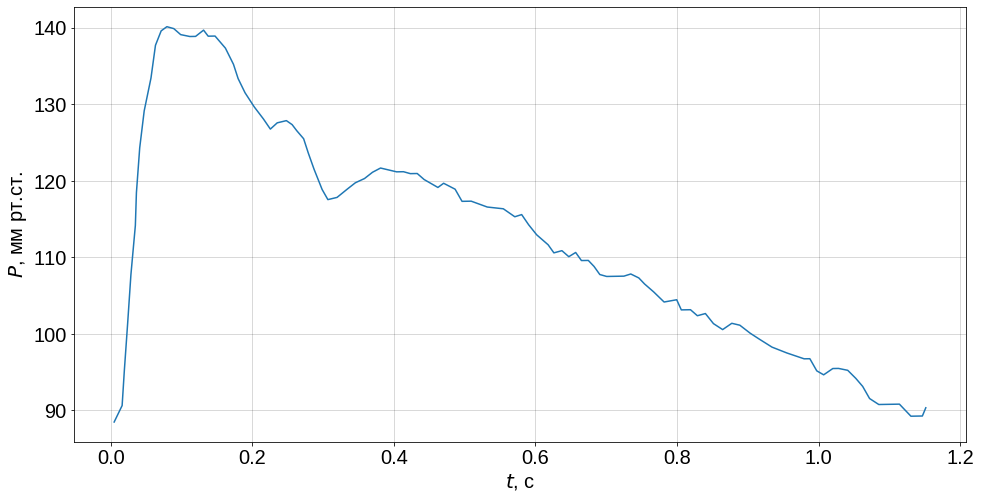

In [13]:
plot_x_y(T, P, "$ t $, с", "$ P $, мм рт.ст.")

#### Сглаживание

In [14]:
# Фильтрация.
n_points = 200
interp1d_params = {}
savgol_filter_params = {"window_length": 9, "polyorder": 3, "mode": "nearest"}

T, P = utils.nonuniform_savgol_filter(T, P, n_points=n_points,
        interp1d_params=interp1d_params, savgol_filter_params=savgol_filter_params)

# Производная.
#savgol_filter_params["deriv"] = 1
#T, der_P = utils.nonuniform_savgol_filter(T, P, n_points=n_points,
#        interp1d_params=interp1d_params, savgol_filter_params=savgol_filter_params)

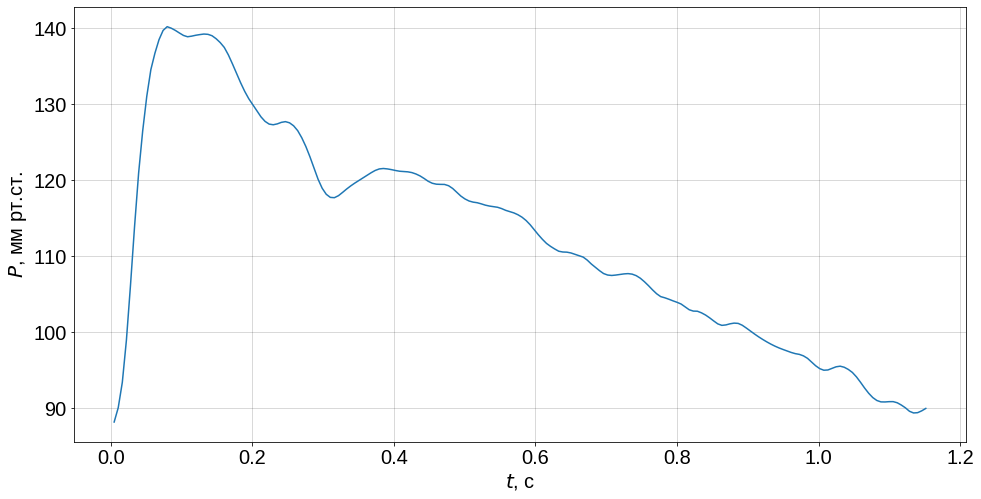

In [15]:
plot_x_y(T, P, "$ t $, с", "$ P $, мм рт.ст.")

In [16]:
test_model.set_P(T, P)#, der_P)

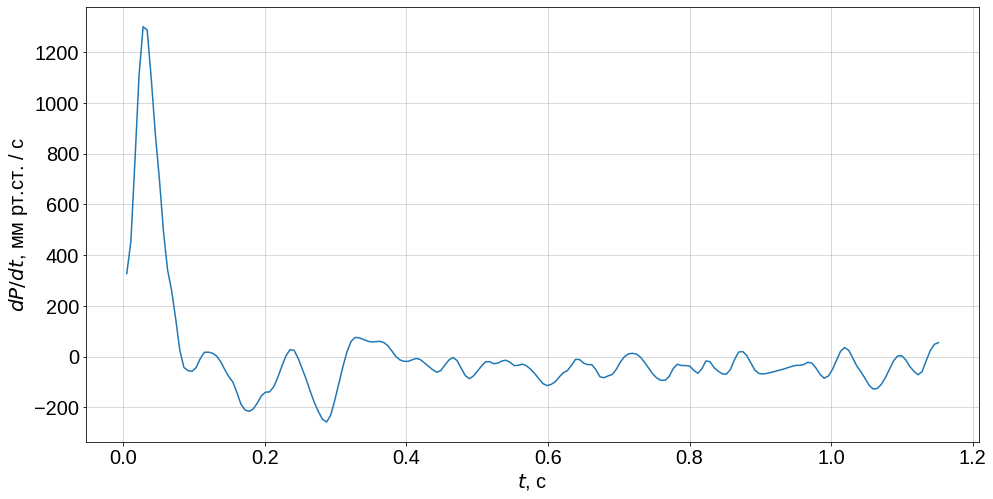

In [17]:
plot_x_y(T, test_model.der_P, "$ t $, с", "$ dP/dt $, мм рт.ст. / с")

#### Получение параметров

In [18]:
P_0, RC, P_out = test_model.get_exp_param()

print("Подобранные параметры: ")
print("P_0:\t%.1f" % P_0)
print("RC:\t%.2f" % RC)
print("P_out:\t%.1f" % P_out)

Подобранные параметры: 
P_0:	116.3
RC:	1.60
P_out:	33.2


/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


### Получение $ Q_{in}(t) $ по $ P(t) $

In [19]:
def Q_in_rhs(t, Q_in):
    return test_model.Q_in_rhs(t, Q_in)#.detach().numpy()

In [20]:
n_cycles = 1
new_T = np.linspace(T[0], T[0] + (T[-1] - T[0]) * n_cycles, T.shape[0] * n_cycles)

In [21]:
result = solve_ivp(Q_in_rhs, (new_T[0], new_T[-1]), np.array([0.0]), t_eval = new_T)

In [22]:
numerical_Q_in = result.y[0]

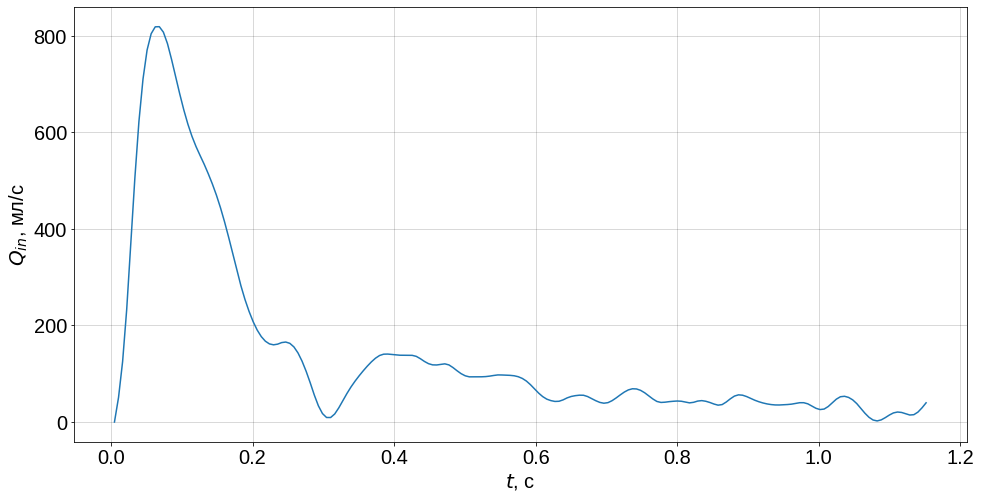

In [23]:
plot_x_y(new_T, numerical_Q_in, "$ t $, с", "$ Q_{in} $, мл/с")